# Lab Exercises: Compressed Gradient Descent

As previously discussed during the class, we can implement compression operators ${\cal C}: \mathbb{R}^d ⟶ \mathbb{R}^d$ on gradient to reduce the communication burden. The compressed gradient descent (CGD) algorithm takes on the following form:
$$
x^{t+1} = x^t - \gamma {\cal C}(\nabla f(x^t))
$$

In this exercise, we will delve into two specific compression techniques: RandK and TopK.

The RandK compressor preserves $k$ coordinates out of $d$, selected uniformly at random. It then scales each coordinate by a factor of $\frac{d}{k}$:
$$
[\text{RandK}(x)]_i = \begin{cases} \frac{d}{k} x_i, &\text{ if the } i \text{-th coordinate is chosen,} \\0, &\text{otherwise.}   \end{cases}
$$

Recalling from the course, this compressor is unbiased:
$$
\mathbb{E}[\text{RandK}(x)] = x \;\; \text{for all } x \in \mathbb{R}^d,
$$
and it bounds the compression error:
$$
\mathbb{E}\|\text{RandK}(x) - x \|^2 \leq \left(\frac{d}{k} - 1 \right) \|x\|^2.
$$

On the other hand, the TopK compressor retains $k$ coordinates with the highest magnitudes, without any scaling. For this compressor, the following inequality holds:
$$
\|\text{TopK}(x) - x \|^2 \leq \left(1 - \frac{k}{d}\right) \|x\|^2.
$$

## The Objective Function

As in the SGD lab exercise, we employ the Ridge Logistic Regression loss:
$$
\min_{x \in \mathbb{R}^d} \left\{f(x) =  \frac{1}{n} \sum_{i=1}^n \log\left\{1 + \exp{\left(-b_i\langle a_i, x\rangle\right)}\right\} + \frac{\lambda}{2} \|x\|^2\right\},
$$
where $b_i \in \{-1, 1\}$ signifies the label of the $i$-th datapoint, and $a_i \in \mathbb{R}^d$ denotes the feature vector of the $i$-th datapoint.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

from sklearn.datasets import make_classification

## Dataset Generation

In [ ]:
np.random.seed(42)
n = 2000
d = 100

data_matrix, labels = make_classification(n_samples = n, n_features=d, n_redundant=0, n_informative= d, n_clusters_per_class=1)
labels = 2*labels - 1

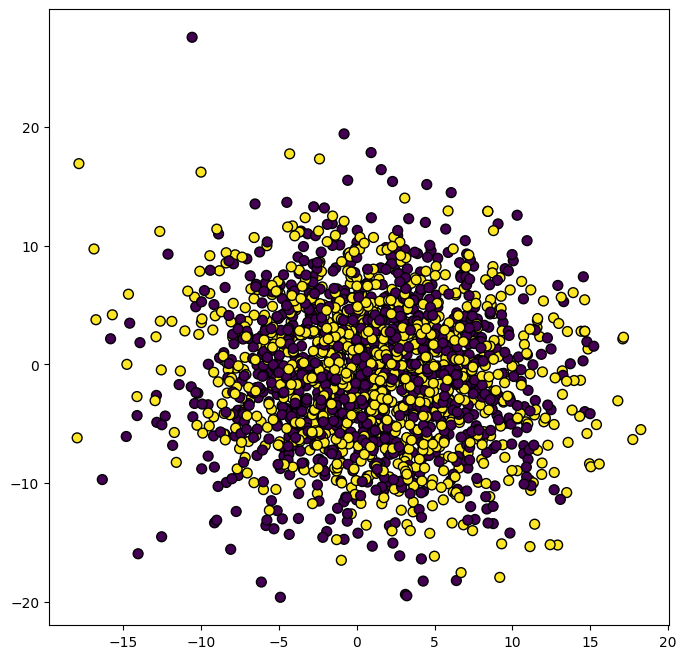

In [ ]:
plt.figure(figsize=(8, 8))

plt.scatter(data_matrix[:, 0], data_matrix[:, 1], marker="o", c=labels, s=50, edgecolor="k")
plt.show()

### Implementing functions $f$, $f_i$ and their gradients

In [ ]:
def individual_log_loss(weights, features, label, regularizer):
  """ Calculate the ridge logistic loss function """
  return np.log(1 + np.exp (- label * features @ weights)) + regularizer * np.linalg.norm(weights, 2) ** 2 / 2

In [ ]:
def individual_log_loss_grad(weights, features, label, regularizer):
  """ Calculate the ridge logistic loss gradient """

  scaler = - 1. / (1. + np.exp(label * features @ weights))

  return scaler * label * features + regularizer * weights

In [ ]:
def log_loss(weights, data_matrix, labels, regularizer):
  """ Calculate the ridge logistic loss for all datapoints """

  log_loss_vector = np.log(1. + np.exp(- labels[:, None] * (data_matrix @ weights)))
  log_loss = log_loss_vector.mean()

  return log_loss + regularizer * np.linalg.norm(weights, 2) ** 2 / 2

In [ ]:
def log_loss_grad(weights, data_matrix, labels, regularizer):
  """ Calculate the ridge logistic loss gradient """

  label_by_features = labels[:, None] * data_matrix

  scalers = - 1. / (1 + np.exp(label_by_features @ weights))

  first_part = (scalers[:, None] * label_by_features).mean(axis=0)
  second_part = regularizer * weights

  return first_part + second_part

In [ ]:
x_0 = np.ones(d)
reg = 1.
log_loss_grad(x_0, data_matrix, labels, reg)[:10]

array([1.13609186, 1.02727349, 1.53178244, 1.06773637, 0.60934615,
       1.50506851, 1.21407282, 0.78463803, 0.81089468, 0.607913  ])

### Finding approximate solutions for different $L_2$-regularitions with Gradient Descent

In [ ]:
def gradient_descent(data_matrix, labels, regularizer, start_iterate, stepsize, num_iterations):
  """ Run Gradient Descent """
  x = np.copy(start_iterate)
  loss_values = [log_loss(x, data_matrix, labels, regularizer)]
  grad_norm_values = [np.linalg.norm(log_loss_grad(x, data_matrix, labels, regularizer), 2) ** 2]

  for i in range(num_iterations):
    print('\r>> Iteration {0} out of {1}'.format(i + 1, num_iterations), end='')
    grad_ = log_loss_grad(x, data_matrix, labels, regularizer)
    x -= stepsize * grad_
    loss_values.append(log_loss(x, data_matrix, labels, regularizer))
    grad_norm_values.append(np.linalg.norm(grad_, 2) ** 2)

  return x, loss_values, grad_norm_values

In [ ]:
def constants(data_matrix, regularizer):
  """ Compute smoothness constants """
  individual_smoothness_constants = []
  for i in range(data_matrix.shape[0]):
    individual_smoothness_constant = 0.25 * np.linalg.norm(data_matrix[i], 2) ** 2 + regularizer
    individual_smoothness_constants.append(individual_smoothness_constant)

  n, d = data_matrix.shape
  objective_function_smoothness_constant = np.linalg.norm(data_matrix.transpose() @ data_matrix / (4 * n) + regularizer * np.eye(d), 2)

  return np.array(individual_smoothness_constants), objective_function_smoothness_constant

In [ ]:
regularizers =  [0.1, 1., 10.]
smoothness_average_costants = []
smoothness_max_constants = []
smoothness_f_constansts = []


for reg in regularizers:
    L_is, L = constants(data_matrix, reg)
    smoothness_f_constansts.append(L)
    smoothness_max_constants.append(max(L_is))
    smoothness_average_costants.append(L_is.mean())

smoothness_average_costants, smoothness_max_constants, smoothness_f_constansts

([863.2298806607765, 864.1298806607765, 873.1298806607765],
 [1524.501150991894, 1525.4011509918942, 1534.4011509918942],
 [27.64939003232422, 28.549390032324215, 37.54939003232422])

In [ ]:
num_iterations_list = [2500, 500, 500]
x_0 = np.ones(d)

x_solutions = []
grad_norms_sets = []
f_values_sets = []

for ind, reg in enumerate(regularizers):
    stepsize = 2. / (smoothness_f_constansts[ind] + reg)
    # stepsize = 1. / smoothness_f_constansts[ind]
    x_solution, loss_values, grad_norm_values = gradient_descent(data_matrix, labels, reg, x_0, stepsize, num_iterations_list[ind])
    x_solutions.append(x_solution)
    grad_norms_sets.append(grad_norm_values)
    f_values_sets.append(loss_values)

>> Iteration 500 out of 500

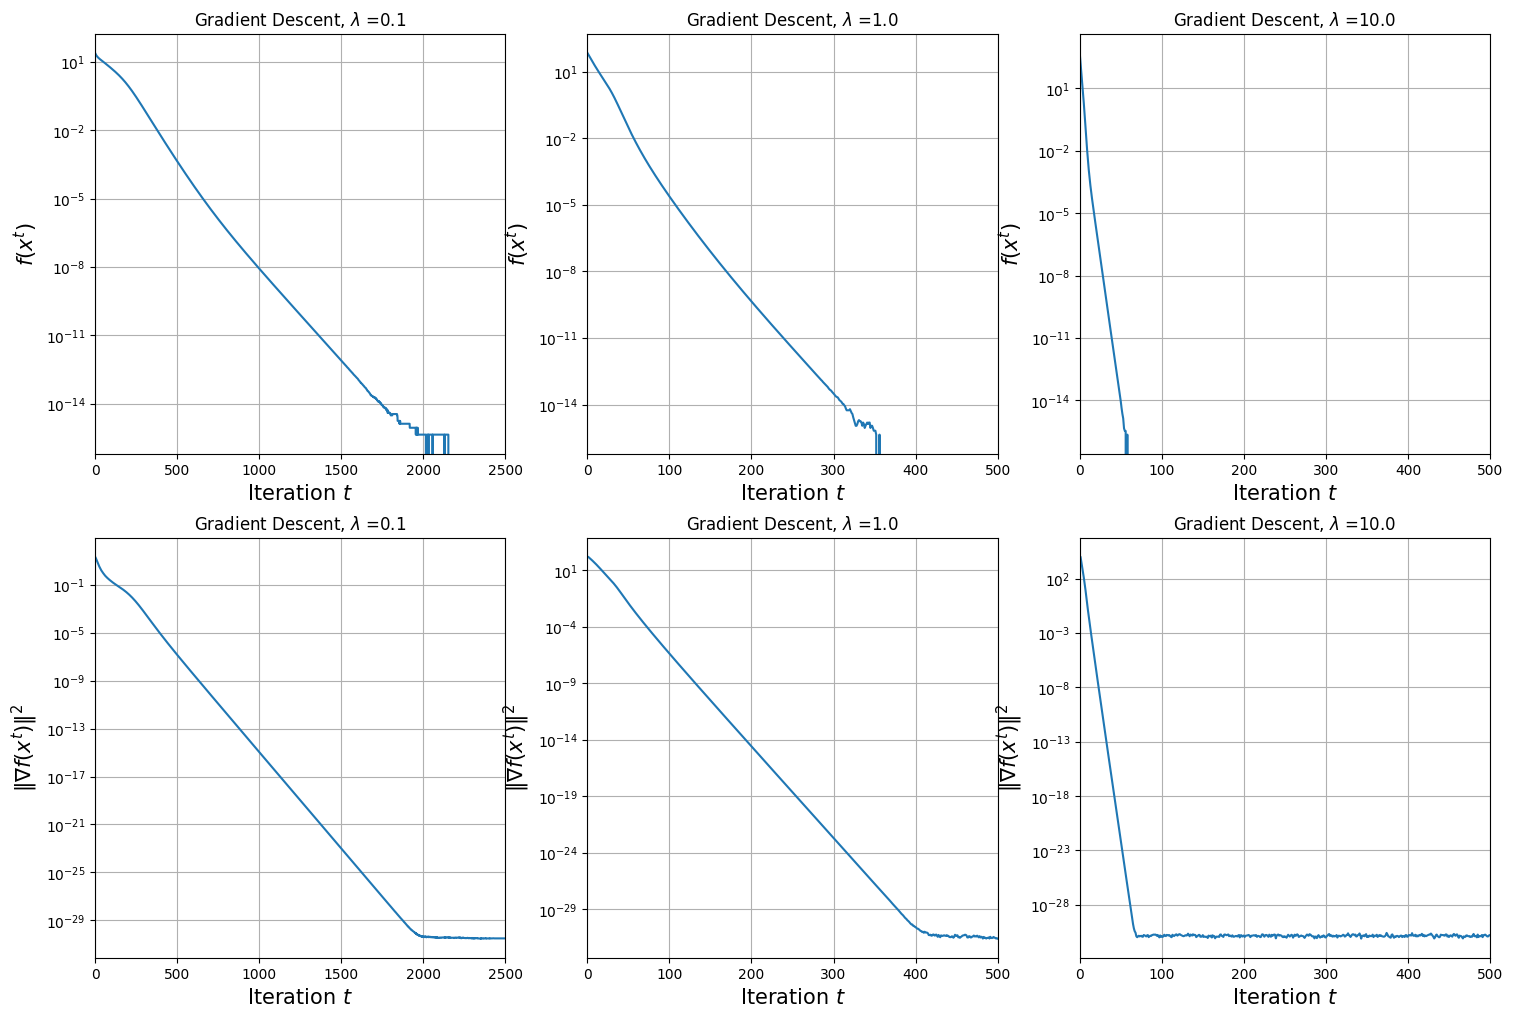

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=len(regularizers))
fig.set_size_inches(18, 12)

#right_lims = [2000, 350, 50]
right_lims = num_iterations_list

for i in range(len(regularizers)):
  right_margin = 100
  ax[0, i].plot(f_values_sets[i][:-right_margin] - f_values_sets[i][-1])
  ax[0, i].set_xlabel(r'Iteration $t$', fontsize=15)
  ax[0, i].set_ylabel(r'$f(x^t)$', fontsize=15)
  ax[0, i].set_title(r'Gradient Descent, $\lambda$ ='+ str(regularizers[i]))
  # ax[0, i].set_yscale('log')
  ax[0, i].set_xlim(left=0, right = right_lims[i])
  ax[0, i].set_yscale('log')
  ax[0, i].grid(True)

  ax[1, i].plot(grad_norms_sets[i])
  ax[1, i].set_xlabel(r'Iteration $t$', fontsize=15)
  ax[1, i].set_ylabel(r'$\|\nabla f(x^t)\|^2$', fontsize=15)
  ax[1, i].set_title(r'Gradient Descent, $\lambda$ ='+ str(regularizers[i]))
  ax[1, i].set_yscale('log')
  ax[1, i].set_xlim(left=0, right = right_lims[i])
  ax[1, i].grid(True)


plt.show()

## Implementing compressors

In this section, you are going to implement both compressors: RandK and TopK. In all experiments, for simplicity we set the parameter $K$ for both compressors equal to one.

In [ ]:
def Top_1(x):
  """ Emulate the Top-1 compressor behaviour """
  a = np.zeros(x.shape[0])
  i = np.argmax(np.abs(x))
  a[i] = x[i]
  return a

def Rand_1(x):
  """ Emulate the Rand-1 compressor behaviour """
  a = np.zeros(x.shape[0])
  i = np.random.choice(x.shape[0])
  a[i] = x[i]
  return a * d

## Laboratory Exercise I: Compressed Gradient Descent on a Single Node

The primary motivation behind Compression Methods is to mitigate the communication burden in distributed learning scenarios. While learning in the single-node setting does not necessitate communication, examining the capabilities of these compressors in simpler, one-node scenarios can provide us with a clearer comprehension of their performance. In this exercise, your task is to contrast biased and unbiased compressors in this specific setting.

In [ ]:
def CGD(data_matrix, labels, regularizer, x_solution, compressor, start_iterate, stepsize, num_iterations):
  """ Run Compressed Gradient Descent """
  x = np.copy(start_iterate)
  loss_values = [log_loss(x, data_matrix, labels, regularizer)]
  dist_values = [np.linalg.norm(x - x_solution, 2) ** 2]

  for i in range(num_iterations):
    print('\r>> Iteration {0} out of {1}'.format(i+1, num_iterations), end='')
    grad_ = log_loss_grad(x, data_matrix, labels, regularizer)
    grad_estimate_ = compressor(grad_)
    x -= stepsize * grad_estimate_
    loss_values.append(log_loss(x, data_matrix, labels, regularizer))
    dist_values.append(np.linalg.norm(x - x_solution, 2) ** 2)

  return x, loss_values, dist_values

In [30]:
loss_values_top_list[2][0]

521.7308174774101

In [ ]:
# x_0 = np.random.normal(1,0, d)
# x_0 = x_0 / np.linalg.norm(x_0)
x_0 = np.ones(d)
num_iterations_list = [1000, 1000, 1000]

loss_values_top_list = []
dist_values_top_list = []
loss_values_rand_list = []
dist_values_rand_list = []

for ind, reg in enumerate(regularizers):
    stepsize_top = 1. / smoothness_f_constansts[ind]
    stepsize_rand = 1. / (d * smoothness_f_constansts[ind])

    print('Top-1')
    _, loss_values_top, dist_values_top = CGD(data_matrix, labels, reg, x_solutions[ind], Top_1, x_0, stepsize_top, num_iterations_list[ind])
    print('\nRand-1')
    _, loss_values_rand, dist_values_rand = CGD(data_matrix, labels, reg, x_solutions[ind], Rand_1, x_0, stepsize_rand, num_iterations_list[ind])
    print('')
    loss_values_top_list.append(loss_values_top)
    dist_values_top_list.append(dist_values_top)
    loss_values_rand_list.append(loss_values_rand)
    dist_values_rand_list.append(dist_values_rand)

Top-1
>> Iteration 1000 out of 1000
Rand-1
>> Iteration 1000 out of 1000
Top-1
>> Iteration 1000 out of 1000
Rand-1
>> Iteration 1000 out of 1000
Top-1
>> Iteration 1000 out of 1000
Rand-1
>> Iteration 1000 out of 1000


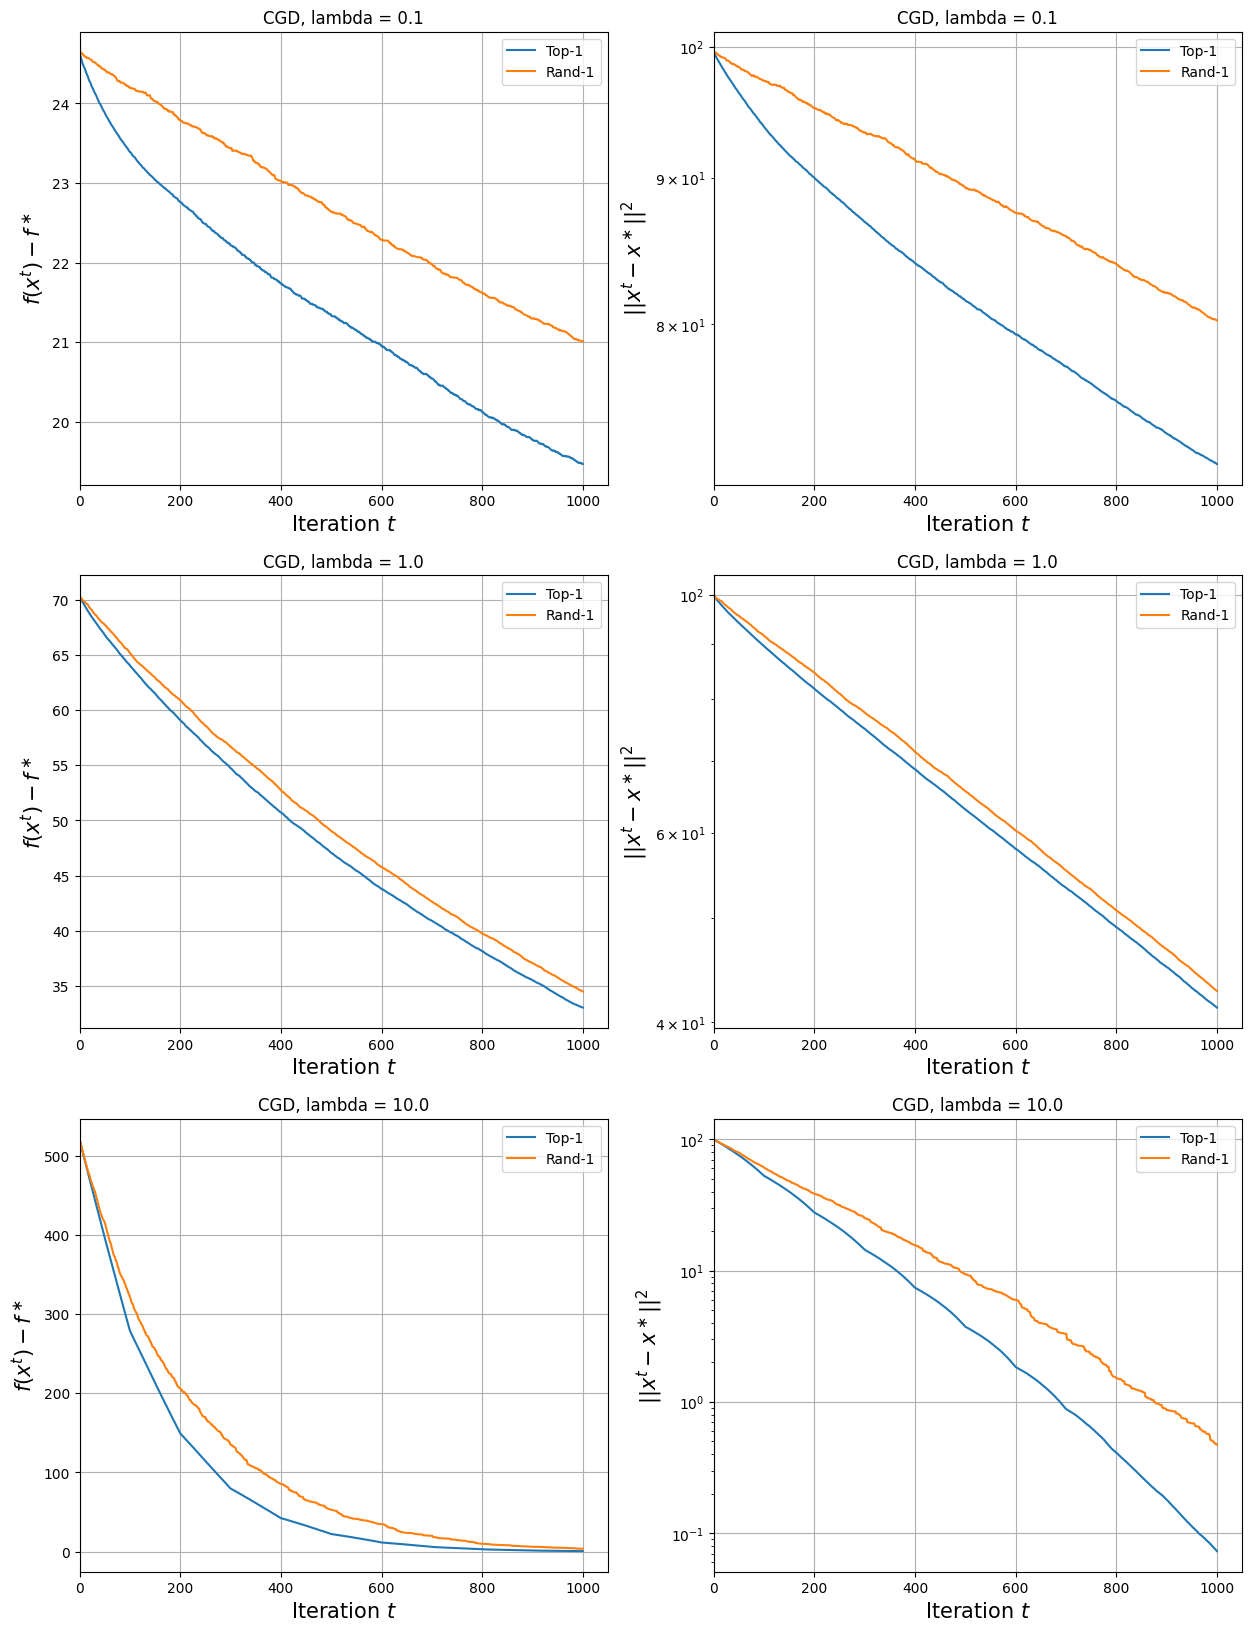

In [27]:
fig, ax = plt.subplots(nrows = len(regularizers), ncols = 2)
fig.set_size_inches(15, 20)
for ind, reg in enumerate(regularizers):
    f_solution = log_loss(x_solutions[ind], data_matrix, labels, reg)
    f_0 = log_loss(x_0, data_matrix, labels, reg)
    ax[ind, 0].plot(np.array(loss_values_top_list[ind]) - f_solution, label ='Top-1')
    ax[ind, 0].plot(np.array(loss_values_rand_list[ind]) - f_solution , label ='Rand-1')
    ax[ind, 0].set_xlabel(r'Iteration $t$', fontsize=15)
    ax[ind, 0].set_ylabel(r'$f(x^t) - f^\ast$', fontsize=15)
    ax[ind, 0].set_title('CGD, lambda = '+ str(reg))
    # ax[ind, 0].set_yscale('log')
    ax[ind, 0].grid(True)
    ax[ind, 0].set_xlim(left=0)
    ax[ind, 0].legend()

    ax[ind, 1].plot(dist_values_top_list[ind], label ='Top-1')
    ax[ind, 1].plot(dist_values_rand_list[ind], label ='Rand-1')
    ax[ind, 1].set_xlabel(r'Iteration $t$', fontsize=15)
    ax[ind, 1].set_ylabel(r'$||x^t - x^\ast||^2$', fontsize=15)
    ax[ind, 1].set_title('CGD, lambda = '+ str(reg))
    ax[ind, 1].set_yscale('log')
    ax[ind, 1].set_xlim(left=0)
    ax[ind, 1].grid(True)
    ax[ind, 1].legend()

plt.show()

## Lab Exercise II: Distributed Compressed Gradient Descent (DCGD)

The DCGD algorithm has got the following form:
$$
x^{t+1} = x^t - \gamma \frac{1}{M} \sum\limits_{i=1}^M {\cal C}_i(\nabla f_i(x^t)).
$$

We are going to compare the performance of this algorithm launched with the same two compressors.

In [35]:
def disributed_compressed_gradient_estimate(weights, data_matrix, labels, regularizer, compressor, num_clients):
    """ Calculate the gradient estimate for the Distributed Gradient Descent algorithm """
    assert data_matrix.shape[0] % num_clients == 0

    num_data_per_client = int(data_matrix.shape[0] / num_clients) # number of data points assigned to each client

    grad_estimate = np.zeros(data_matrix.shape[1])
    for i in range(num_clients):
        client_gradient = np.zeros(d)

        for j in range(num_data_per_client * i, num_data_per_client * (i+1)):
            client_gradient += individual_log_loss_grad(weights, data_matrix[j], labels[j], regularizer)

        client_gradient /= num_data_per_client
        grad_estimate += compressor(client_gradient)

    grad_estimate /= num_clients

    return grad_estimate

def DCGD(data_matrix, labels, regularizer, x_solution, compressor, num_clients, start_iterate, stepsize, num_iterations):
    """ Run the Distributed Compressed Gradient Descent """

    x = np.copy(start_iterate)
    loss_values = [log_loss(x, data_matrix, labels, regularizer)]
    dist_values = [np.linalg.norm(x - x_solution, 2) ** 2]

    for k in range(num_iterations):
        print('\r>> Iteration {0} out of {1}'.format(k+1, num_iterations), end='')
        x -= stepsize * disributed_compressed_gradient_estimate(x, data_matrix, labels, regularizer, compressor, num_clients)

        loss_values.append(log_loss(x, data_matrix, labels, regularizer))
        dist_values.append(np.linalg.norm(x - x_solution, 2) ** 2)

    return x, loss_values, dist_values

In [36]:
num_clients = 10

### Computing smoothness constants for client functions

In [37]:
L_is_list = []

assert data_matrix.shape[0] % num_clients == 0
num_data_per_client = int(n / num_clients)

for reg in regularizers:
    L_is = []
    for i in range(num_clients):
      local_data = data_matrix[num_data_per_client * i : num_data_per_client * (i + 1), :]
      L_is.append( np.linalg.norm(local_data.transpose() @ local_data / (4 * num_data_per_client), 2) + reg)
    L_is_list.append(L_is)

client_max_smoothness_constants = [max(x) for x in L_is_list]

In [38]:
client_max_smoothness_constants

[38.60643623114154, 39.506436231141535, 48.506436231141535]

In [39]:
x_0 = np.ones(d)
# x_0 = x_0 / np.linalg.norm(x_0, 2)
num_iterations = 50

results_top_list = []
results_rand_list = []

for ind, reg in enumerate(regularizers):
  # TODO: Add your own strategy for setting the stepsize for DCGD with Top-1 Compressor
  stepsizes_top = [smoothness_f_constansts[ind] + j * client_max_smoothness_constants[ind] for j in [0, 5, 10]]
  results_top = []
  for ind, stepsize_top in enumerate(stepsizes_top):
        print('Top - 1: strategy {0} out of {1}'.format(ind + 1, len(stepsizes_top)))
        print(stepsize)
        result = DCGD(data_matrix, labels, reg, x_solutions[ind], Top_1, num_clients, x_0, stepsize_top, num_iterations)
        print('')
        results_top.append(result)

  stepsize_rand = 1. / (smoothness_f_constansts[ind] + 2 * (d - 1) * client_max_smoothness_constants[ind] / num_clients)

  print('Rand - 1')
  result_rand = DCGD(data_matrix, labels, reg, x_solutions[ind], Rand_1, num_clients, x_0, stepsize_rand, num_iterations)
  print('')
  results_top_list.append(results_top)
  results_rand_list.append(result_rand)

Top - 1: strategy 1 out of 3
0.04206152799521495
>> Iteration 3 out of 50

<ipython-input-8-23b2996e4992>:4: RuntimeWarning: overflow encountered in exp
  log_loss_vector = np.log(1. + np.exp(- labels[:, None] * (data_matrix @ weights)))


>> Iteration 50 out of 50
Top - 1: strategy 2 out of 3
0.04206152799521495
>> Iteration 50 out of 50
Top - 1: strategy 3 out of 3
0.04206152799521495
>> Iteration 50 out of 50
Rand - 1
>> Iteration 50 out of 50
Top - 1: strategy 1 out of 3
0.04206152799521495
>> Iteration 50 out of 50
Top - 1: strategy 2 out of 3
0.04206152799521495
>> Iteration 50 out of 50
Top - 1: strategy 3 out of 3
0.04206152799521495
>> Iteration 50 out of 50
Rand - 1
>> Iteration 50 out of 50
Top - 1: strategy 1 out of 3
0.04206152799521495
>> Iteration 50 out of 50
Top - 1: strategy 2 out of 3
0.04206152799521495
>> Iteration 50 out of 50
Top - 1: strategy 3 out of 3
0.04206152799521495
>> Iteration 50 out of 50
Rand - 1
>> Iteration 50 out of 50


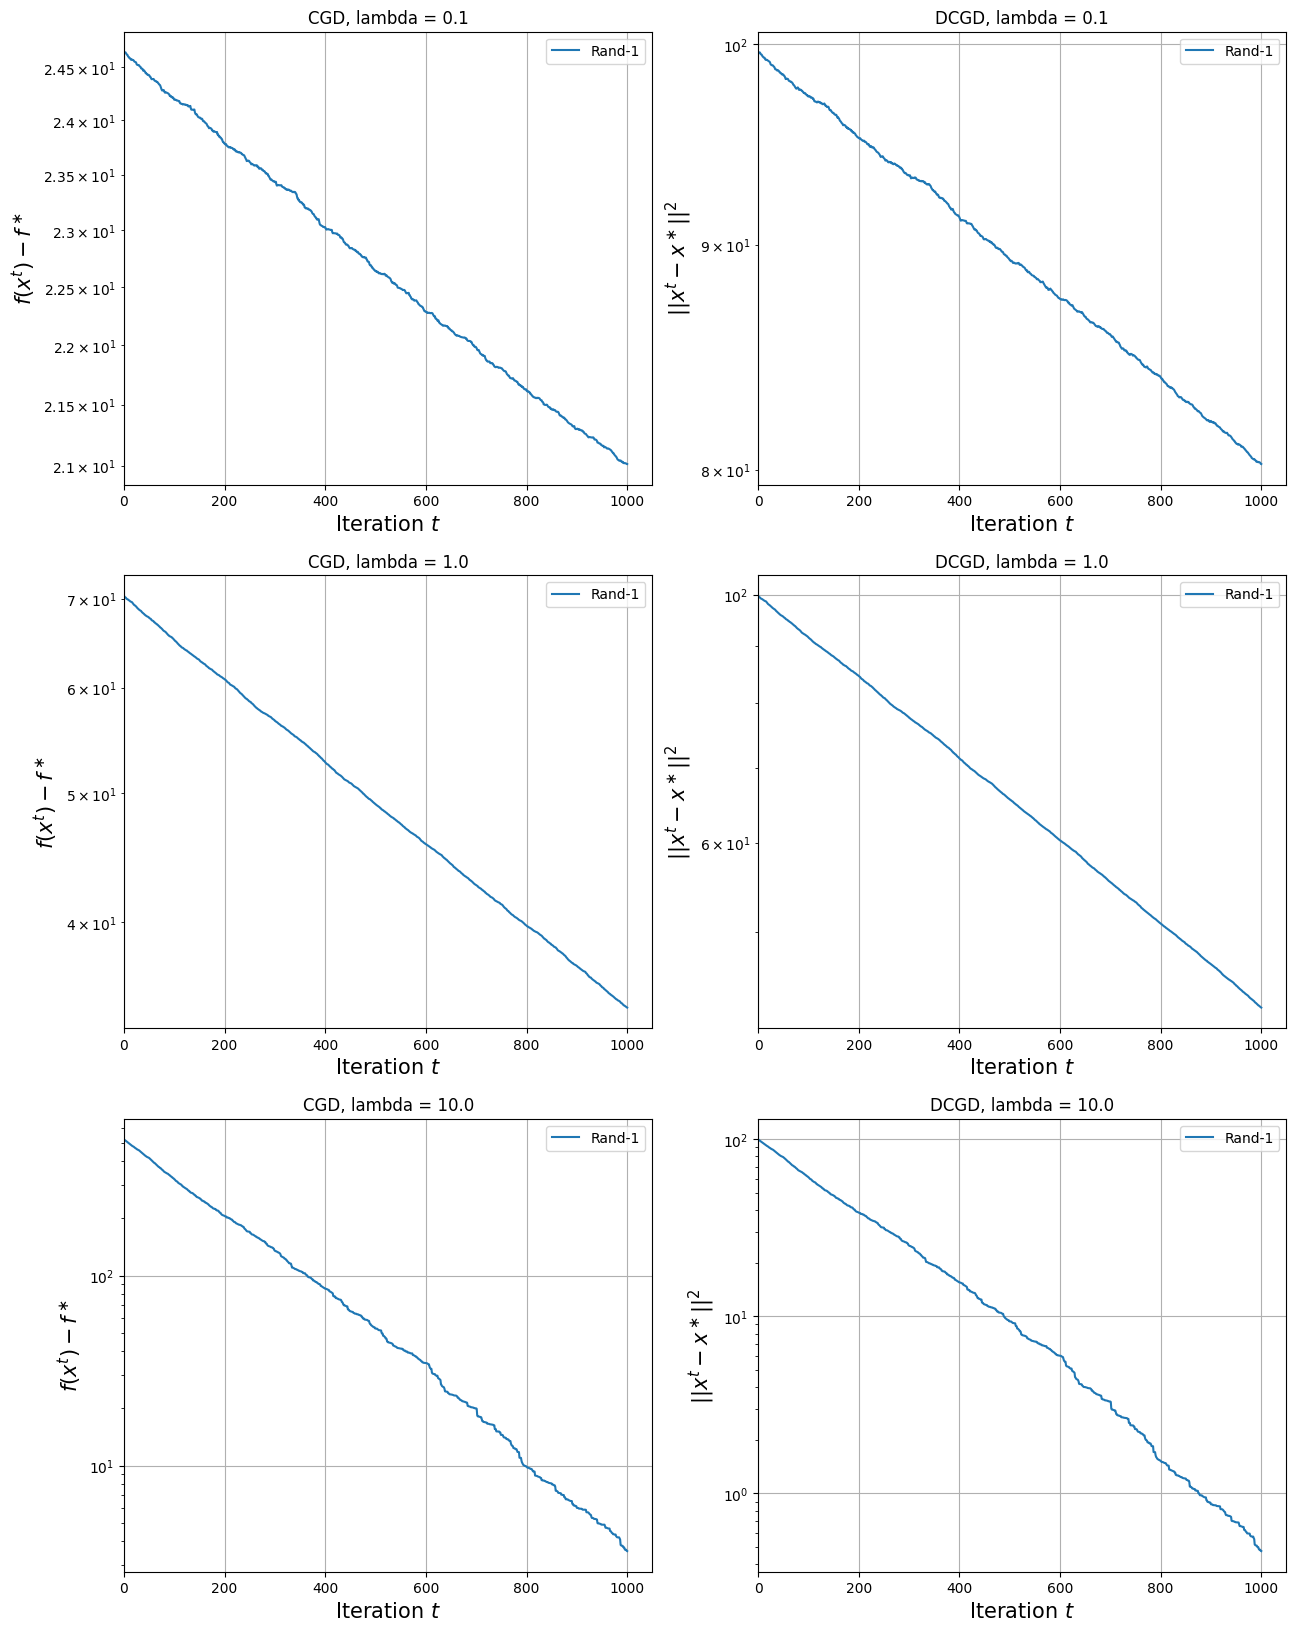

In [42]:
fig, ax = plt.subplots(nrows = len(regularizers), ncols = 2)
fig.set_size_inches(15, 20)
for ind, reg in enumerate(regularizers):
    f_solution = log_loss(x_solutions[ind], data_matrix, labels, reg)
    f_0 = log_loss(x_0, data_matrix, labels, reg)
    # for ind2, result in enumerate(results_top_list[ind]):
    #   x, loss_values, dist_values = result
    #   ax[ind, 0].plot(np.array(loss_values) - f_solution, label ='Top-1, strategy {}'.format(ind2))
    #   ax[ind, 1].plot(dist_values, label ='Top-1, strategy {}'.format(ind2))
    ax[ind, 0].plot(np.array(loss_values_rand_list[ind]) - f_solution , label ='Rand-1')
    ax[ind, 0].set_xlabel(r'Iteration $t$', fontsize=15)
    ax[ind, 0].set_ylabel(r'$f(x^t) - f^\ast$', fontsize=15)
    ax[ind, 0].set_title('CGD, lambda = '+ str(reg))
    ax[ind, 0].set_yscale('log')
    ax[ind, 0].grid(True)
    ax[ind, 0].set_xlim(left=0)
    ax[ind, 0].legend()

    ax[ind, 1].plot(dist_values_rand_list[ind], label ='Rand-1')
    ax[ind, 1].set_xlabel(r'Iteration $t$', fontsize=15)
    ax[ind, 1].set_ylabel(r'$||x^t - x^\ast||^2$', fontsize=15)
    ax[ind, 1].set_title('DCGD, lambda = '+ str(reg))
    ax[ind, 1].set_yscale('log')
    ax[ind, 1].set_xlim(left=0)
    ax[ind, 1].grid(True)
    ax[ind, 1].legend()

plt.show()

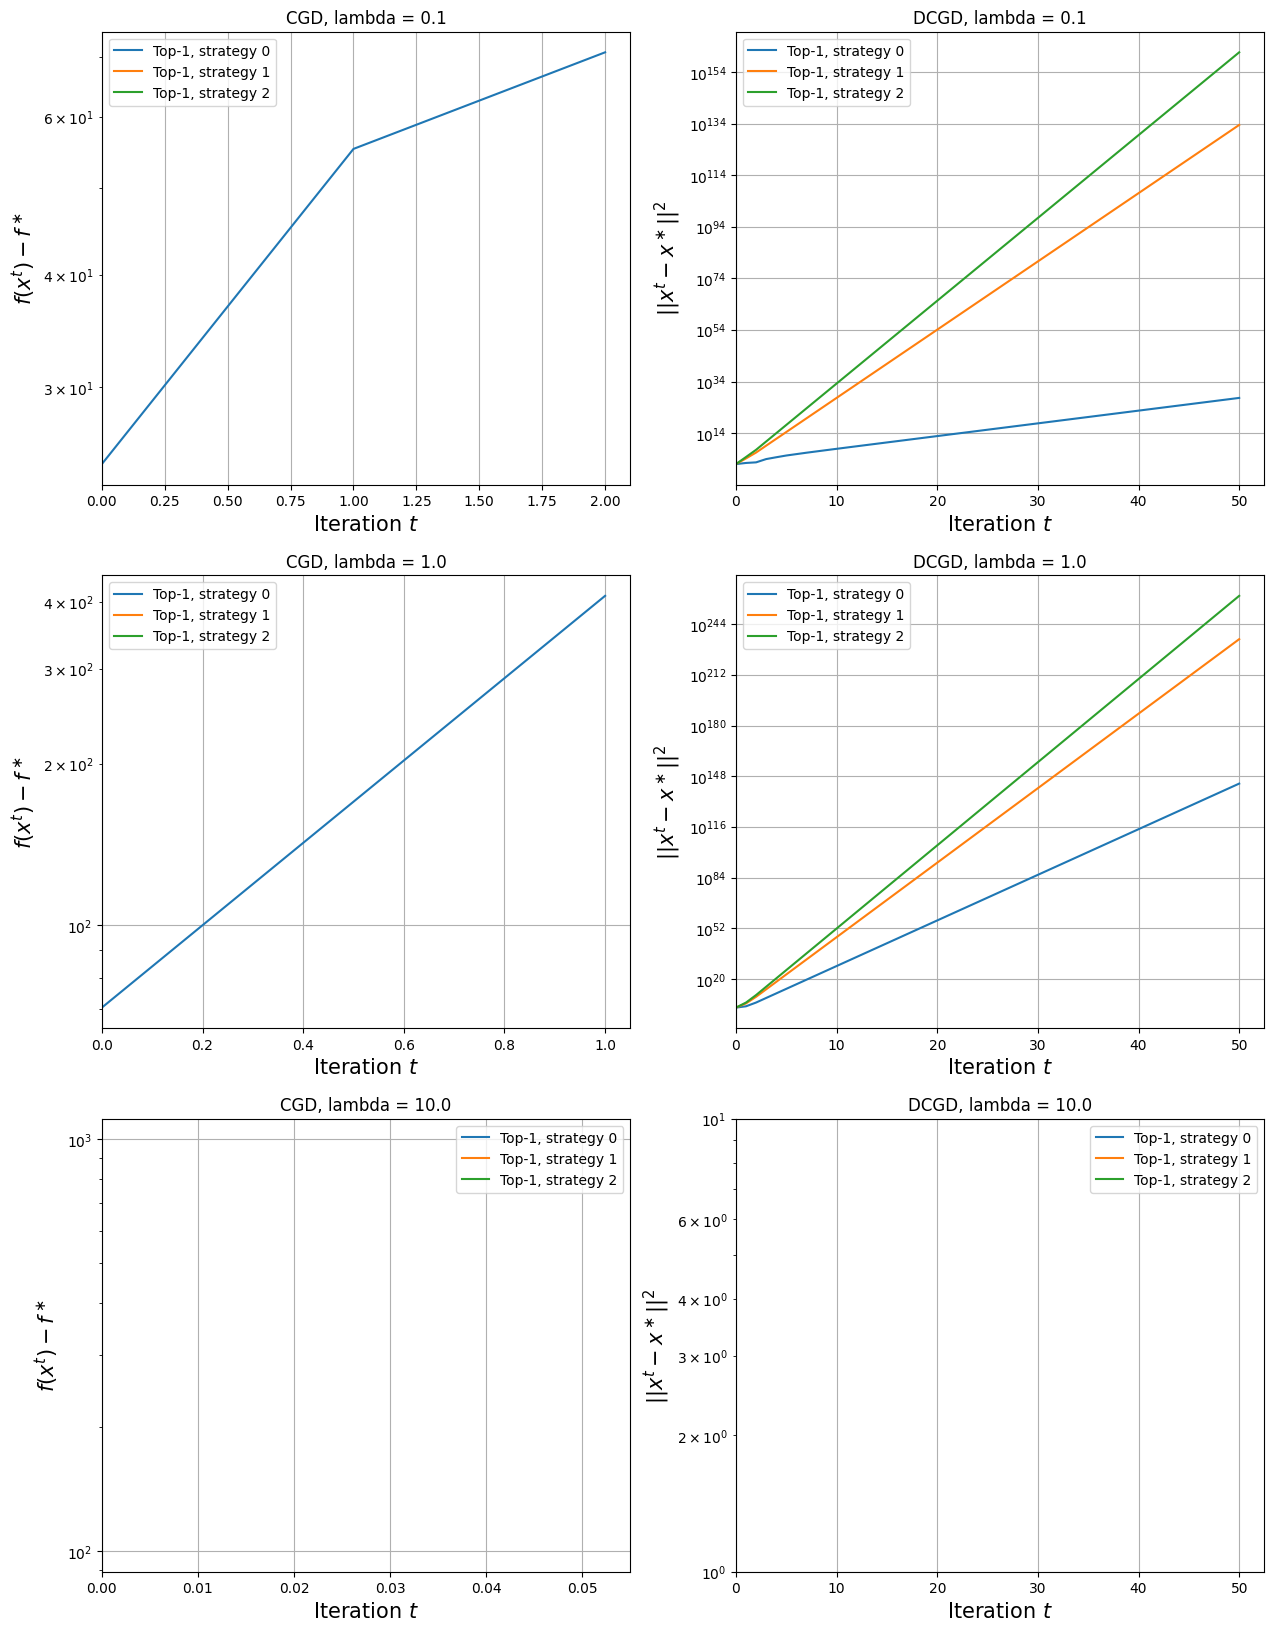

In [43]:
fig, ax = plt.subplots(nrows = len(regularizers), ncols = 2)
fig.set_size_inches(15, 20)
for ind, reg in enumerate(regularizers):
    f_solution = log_loss(x_solutions[ind], data_matrix, labels, reg)
    f_0 = log_loss(x_0, data_matrix, labels, reg)
    for ind2, result in enumerate(results_top_list[ind]):
      x, loss_values, dist_values = result
      ax[ind, 0].plot(np.array(loss_values) - f_solution, label ='Top-1, strategy {}'.format(ind2))
      ax[ind, 1].plot(dist_values, label ='Top-1, strategy {}'.format(ind2))
    # ax[ind, 0].plot(np.array(loss_values_rand_list[ind]) - f_solution , label ='Rand-1')
    ax[ind, 0].set_xlabel(r'Iteration $t$', fontsize=15)
    ax[ind, 0].set_ylabel(r'$f(x^t) - f^\ast$', fontsize=15)
    ax[ind, 0].set_title('CGD, lambda = '+ str(reg))
    ax[ind, 0].set_yscale('log')
    ax[ind, 0].grid(True)
    ax[ind, 0].set_xlim(left=0)
    ax[ind, 0].legend()

    # ax[ind, 1].plot(dist_values_rand_list[ind], label ='Rand-1')
    ax[ind, 1].set_xlabel(r'Iteration $t$', fontsize=15)
    ax[ind, 1].set_ylabel(r'$||x^t - x^\ast||^2$', fontsize=15)
    ax[ind, 1].set_title('DCGD, lambda = '+ str(reg))
    ax[ind, 1].set_yscale('log')
    ax[ind, 1].set_xlim(left=0)
    ax[ind, 1].grid(True)
    ax[ind, 1].legend()

plt.show()

As anticipated, DCGD with the unbiased compressor Rand-1 exhibits convergence. In general, there is no theoretical evidence supporting the convergence of DCGD with biased compressors. Furthermore, negative results have been reported, demonstrating that the algorithm can indeed diverge, as exemplified in this exercise. For further insights into theoretical divergence examples, please refer to [1] and [2].

[1] [Error Feedback Fixes SignSGD and other Gradient Compression Schemes](https://proceedings.mlr.press/v97/karimireddy19a.html), Karimeddy et al.

[2] [On Biased Compression for Distributed Learning](https://arxiv.org/abs/2002.12410), Beznosikov et al.